## Setup

#### Install Dependencies

In [1]:
#!pip install labelme albumentations

In [2]:
# !pip install tensorflow-gpu tensorflow matplotlib opencv-python

In [3]:
#!pip install tensorflow matplotlib opencv-python

#### Collect Images with Opencv

In [4]:
import os
import time
import uuid # allows to create unique filenames automatically uuid.uuid1()
import cv2

In [5]:
IMAGES_PATH = os.path.join('data', 'images')
images_no = 30

In [8]:
# cap = cv2.VideoCapture(0) # Connecting to Video camera
# for imgnum in range(images_no):
#     print('Collecting image {}'.format(imgnum))
    
#     # Read a frame from the capture device
#     ret, frame = cap.read() # read from device used to  capture
    
#     # Check if the frame is empty
#     if not ret:
#         print("Error: Failed to capture frame.")
#         break
    
#     # Generate a unique filename for the image using UUID
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    
    
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
    
#     # Pause for 0.5 seconds before capturing the next image
#     time.sleep(0.5)
    
#     # Check if the 'q' key is pressed, and break the loop if true
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the video capture device
# cap.release()

# # Close all OpenCV windows
# cv2.destroyAllWindows()

cv2.imwrite(imgname, frame):
This line uses the imwrite function from the OpenCV library.
It saves the captured frame (frame) as an image file with the specified filename (imgname). The image format is determined by the file extension in imgname (e.g., '.jpg').

cv2.imshow('frame', frame):
This line uses the imshow function from OpenCV for displaying images.
It displays the captured frame (frame) in a window named 'frame'. This is optional and mainly used for real-time visualization during the image capturing process.

#### Annotate Images with LabelMe

In [9]:
# !labelme

2024-02-25 10:17:28,923 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\HP\.labelmerc


In [10]:
import tensorflow as tf
import json # Work with json files for label
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# List all the GPU devices on my machine
gpus = tf.config.experimental.list_physical_devices('GPU')

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# Limiting the memory and telling the GPUs not to use up all the memory
# The GPUs can only use what they need

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
# Find out if GPU is availaable
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [14]:
tf.config.list_physical_devices('GPU')

[]

#### Load Image into Tensorflow Pipeline

In [15]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [16]:
images.as_numpy_iterator().next()

b'data\\images\\2a344b32-d3be-11ee-9e7f-acfdce6b3a54.jpg'

In [17]:
from FaceDetection import load_image

In [18]:
images = images.map(load_image)

images.as_numpy_iterator().next()

In [19]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

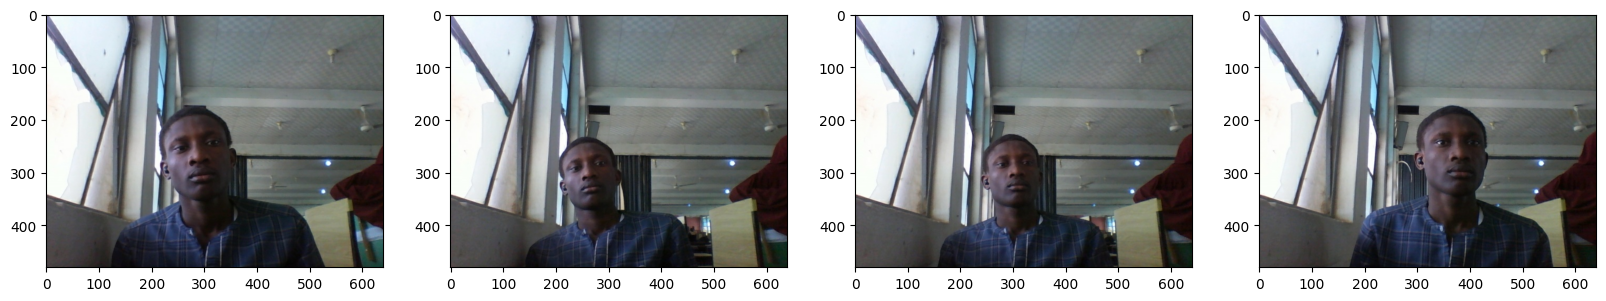

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partition Unaugmented Data

 - Manually split data into train, test, validation set
    - create respective folders in the data directory
    - inside the ```train```, ```test```, ```val```, folders create ```images``` and ```labels``` folder
    - Move images into the folders in this project (63 to train, 14 to test, 13 to val)

#### Move Matching Labels

In [21]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## Augment Images and Labels with Albumentations

In [13]:
# !pip install albumentations
import albumentations as alb